## Question Formulation

In this final project we seek to perform Click Through Rate (CTR) prediction on a large public dataset of Criteo advertising data.  This data was made available as part of a Kaggle competition several years ago.  CTR is an important and commonly used metric in Internet marketing.  It measures the number of clicks advertisers receive on their ads per number of impressions ((Total Clicks on Ad) / (Total Impressions) = Click Through Rate).  In simple terms, a  high CTR means that a high percentage of people who see an ad click on it.  Thus, ads with a high CTR can be thought of as high performing, and the companies serving these ads can charge more for them.

The winner of the Criteo Kaggle competition achieved a log-loss score of 0.445.  With 718 competition entries, all entries performing above the 90th percentile achieved a log-loss score of 0.46 or less.  While reaching a score this low would be ideal, our model could still be practically useful (especially if it was applied to other datasets) with a slightly higher log-loss score, such as around 0.50.

In pursuit of our ultimate goal of performing CTR prediction on a public dataset of Criteo advertising data, we will perform an exploratory data analysis (EDA), and from this EDA determine if logistic regression is an appropriate algorithm to use for CTR prediction.  This will include thoroughly testing its assumption.  If we determine it is appropriate, we will then apply logistic regression to a toy example (an artificial example) to test our general algorithm implementation.  Our target variable will be the ###CTR for a specific display ad### before applying the same algorithm to a full test and train split.  We will seek to optimize our implementation of the algorithm to achieve a log-loss score of 0.50 or lower.

Some of the limitations of the dataset include the fact that many of the columns in it are categorical in nature.  To be able to use them with logistic regression, which only accepts numeri

###maybe describe algorithm (logistic regression in this section more) as opposed to starting discussion in EDA).###

### Discuss more the limitations of the data and/or algorithm ###

LImitations: We have a bunch of categorical columns


## Setup

In [3]:
# Installation of necessary packages

# !pip install --upgrade pip
# !pip install --upgrade pandas
# !pip install --upgrade google-api-python-client
# !pip install --upgrade seaborn
# !pip install --upgrade networkx
# !pip install --upgrade matplotlib
# !pip install --upgrade pyspark
# !pip install --upgrade pyspark_dist_explore


In [127]:
# Main Imports

from IPython.display import display, HTML, display_html #usefull to display wide tables
from pyspark_dist_explore import Histogram, hist, distplot, pandas_histogram
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
#from pyspark.mllib.linalg import VectorUDT
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.linalg import SparseVector
from pyspark.sql import functions as F, types
from pyspark.sql.functions import (explode, col)
from pyspark.sql.functions import col, row_number, concat, lit
from pyspark.sql.functions import trim
from pyspark.sql.functions import udf
from pyspark.sql.functions import split
from pyspark.sql.types import ArrayType, StructType, StructField, LongType, StringType
from pyspark.sql.types import Row
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

import ast
import datetime
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import pickle
import re
import seaborn as sns
import time


In [5]:
# To better display plot from matplotlib
%matplotlib inline


In [1]:
# Begin Spark Session - ensure that kernel is PySpark and not Python 2 or Python 3
spark

In [6]:
# Create Spark Context
sc = spark.sparkContext

## EDA & Discussion of Challenges

Before we begin modeling an alogrithm for Click Through rate prediction, we should first examine the Criteo dataset that we will be using.  To do this, we will examine the initial format and structure of the dataset, the size of the dataset, examine it for missing values and outliers, and capture several summary statistics that will inform us of the distribution of the dataset.  To aid in our analysis, we will plot several graphs that will augment our understanding of the distribution of the dataset.

Furthermore, as mentioned in our question formulation, we would like to use logistic regression as the main algorithm in our Click Through Rate prediction.  However, logistic regression models have several assumptions that must be met before they can be used.

The assumptions for logistic regression include:

1)  The outcome is a binary or dichotomous variable (e.g. “yes” or “no”, “positive” or “negative”, 1 or 0).

2)  There is a linear relationship between the logit of the outcome and each predictor variables.  The logit function is $$logit(p) = log(p/(1-p))$$ where p is the probability of the outcome.

3) Independence of observations.

4) There is no multicollinearity among the independent variables.

5) ??? There are a large number of observations.

In the EDA that follows, we will show how the Criteo dataset meets the assumptions necessary for logistic regression, thus allowing us to comfortably use it as our prediction algorithm.


### The Dataset is Large and Needs to be Parsed

After loading the data and performing a row count, we can observe that the Criteo dataset is quite large.  It contains 45,840,617 rows (records). ??? reiterate what these are???

Additionally, we can observe that each row in the dataset is initally a single, long string with tab-delimited columns.  These will need to be parsed before any further analysis can be performed.  We wrote code that performs this task, and separates all of these columns into numerical values or strings as appropriate.

In [7]:
rawDF = sqlContext.read.text('gs://w261_final_project_ajh_bucket/data/train.txt').withColumnRenamed("value", "text")
rawDF.cache()
rawDF_count = rawDF.count()
print(rawDF_count)

45840617


In [51]:
rawDF.printSchema()
rawDF.first()

root
 |-- text: string (nullable = true)



Row(text='0\t1\t1\t5\t0\t1382\t4\t15\t2\t181\t1\t2\t\t2\t68fd1e64\t80e26c9b\tfb936136\t7b4723c4\t25c83c98\t7e0ccccf\tde7995b8\t1f89b562\ta73ee510\ta8cd5504\tb2cb9c98\t37c9c164\t2824a5f6\t1adce6ef\t8ba8b39a\t891b62e7\te5ba7672\tf54016b9\t21ddcdc9\tb1252a9d\t07b5194c\t\t3a171ecb\tc5c50484\te8b83407\t9727dd16')

In [46]:
rawDF

DataFrame[text: string]

In [54]:
fullWithColsDF = rawDF.withColumn('tmp', split('text', '\t')).\
                    select( col("tmp").getItem(0).cast("double").alias("label")
                    , col("tmp").getItem(1).cast("double").alias("int_1")
                    , col("tmp").getItem(2).cast("double").alias("int_2")
                    , col("tmp").getItem(3).cast("double").alias("int_3")
                    , col("tmp").getItem(4).cast("double").alias("int_4")
                    , col("tmp").getItem(5).cast("double").alias("int_5")
                    , col("tmp").getItem(6).cast("double").alias("int_6")
                    , col("tmp").getItem(7).cast("double").alias("int_7")
                    , col("tmp").getItem(8).cast("double").alias("int_8")
                    , col("tmp").getItem(9).cast("double").alias("int_9")
                    , col("tmp").getItem(10).cast("double").alias("int_10")
                    , col("tmp").getItem(11).cast("double").alias("int_11")
                    , col("tmp").getItem(12).cast("double").alias("int_12")
                    , col("tmp").getItem(13).cast("double").alias("int_13")
                    , col("tmp").getItem(14).alias("categ_1")
                    , col("tmp").getItem(15).alias("categ_2")
                    , col("tmp").getItem(16).alias("categ_3")
                    , col("tmp").getItem(17).alias("categ_4")
                    , col("tmp").getItem(18).alias("categ_5")
                    , col("tmp").getItem(19).alias("categ_6")
                    , col("tmp").getItem(20).alias("categ_7")
                    , col("tmp").getItem(21).alias("categ_8")
                    , col("tmp").getItem(22).alias("categ_9")
                    , col("tmp").getItem(23).alias("categ_10")
                    , col("tmp").getItem(24).alias("categ_11")
                    , col("tmp").getItem(25).alias("categ_12")
                    , col("tmp").getItem(26).alias("categ_13")
                    , col("tmp").getItem(27).alias("categ_14")
                    , col("tmp").getItem(28).alias("categ_15")
                    , col("tmp").getItem(29).alias("categ_16")
                    , col("tmp").getItem(30).alias("categ_17")
                    , col("tmp").getItem(31).alias("categ_18")
                    , col("tmp").getItem(32).alias("categ_19")
                    , col("tmp").getItem(33).alias("categ_20")
                    , col("tmp").getItem(34).alias("categ_21")
                    , col("tmp").getItem(35).alias("categ_22")
                    , col("tmp").getItem(36).alias("categ_23")
                    , col("tmp").getItem(37).alias("categ_24")
                    , col("tmp").getItem(38).alias("categ_25")
                    , col("tmp").getItem(39).alias("categ_26")
                    ).cache()

## 13 Numerical Columns, 26 Categorical Columns

After parsing our data and separating the columns, we can see that there are 13 numerical columns and 26 categorical columns.  The numerical columns appear to be all integer values, while the categorical columns appear to be hash values.

In [128]:
fullWithColsDF.first()


Row(label=0.0, int_1=1.0, int_2=1.0, int_3=5.0, int_4=0.0, int_5=1382.0, int_6=4.0, int_7=15.0, int_8=2.0, int_9=181.0, int_10=1.0, int_11=2.0, int_12=None, int_13=2.0, categ_1='68fd1e64', categ_2='80e26c9b', categ_3='fb936136', categ_4='7b4723c4', categ_5='25c83c98', categ_6='7e0ccccf', categ_7='de7995b8', categ_8='1f89b562', categ_9='a73ee510', categ_10='a8cd5504', categ_11='b2cb9c98', categ_12='37c9c164', categ_13='2824a5f6', categ_14='1adce6ef', categ_15='8ba8b39a', categ_16='891b62e7', categ_17='e5ba7672', categ_18='f54016b9', categ_19='21ddcdc9', categ_20='b1252a9d', categ_21='07b5194c', categ_22='', categ_23='3a171ecb', categ_24='c5c50484', categ_25='e8b83407', categ_26='9727dd16')

### Methods for Calculating Statistics

Below are several methods that we use to calculate summary statistics, and perform any necessary transformations.  They include:

1) f_calc_stats, which calculates mean, minimum value, maximum value, standard deviation, variance, skewness of a column in a dataframe.
2) f_check_null, which calculates count of null or NaN or empty for a column.
3) f_display_stats_categ, which calculates count of unique values and empty strings for a column.
4) f_display_stats_int, which calls other functions to get mean, minimum value, maximum value, standard deviation, variance, skewness, and number of nulls/NaN/empty values of a column in a dataframe.
5) f_display_corr, which calculates the correlation and covariance of a variable against the label.
6) f_covert_to_df, which converts an RDD to dataframe.
7) f_cast_str_to_int, which converts integer columns formatted as strings to integers.
8) f_remove_empty_string, which removes rows where at least one column has empty string.

In [72]:
def f_calc_stats(data, column):
    """
    Calculates mean, minimum value, maximum value, standard deviation, variance, skewness of a column in a dataframe.
    Returns a list containing mean, minimum value, maximum value, standard deviation, variance, skewness
    Arguments:
        data         - dataframe on which we are calculating statistics.
        column       - column for which statistics have to be calculated
    Returns:
        A list containing the mean, minimum value, maximum value, standard deviation, variance, skewness of the column.
    """
    
    return data.agg(F.avg(data[column]), F.min(data[column]), F.max(data[column]),
                    F.stddev_pop(data[column]),F.var_pop(data[column]),F.skewness(data[column])
                   ).collect()

In [73]:
def f_check_null(data, column):
    """
    Calculates count of null or NaN or empty for a column.
    Returns an integer for the count  of null or NaN or empty for a column.
    Arguments:
        data         - dataframe on which we are calculating the metric.
        column       - column for which the metric has to be calculated.
    Returns:
        An integer for the count where the column is null or NaN or empty.
    """
    return data.filter( (data[column] =="") |F.isnull(data[column])|F.isnan(data[column])
                      ).count()

In [74]:
# Checking cardinality
def f_display_stats_categ(df, inColList):
    """
    Calculates count of unique values and empty strings for a column.
    Displays the output as a HTML table.
    Arguments:
        df         - dataframe on which we are calculating the metric.
        inColList  - list of column names for which we are calculating the metrics.
    Returns:
        Displays the output as a HTML table.
    """
    dict1={}
    for col in inColList:
        cardinal_cnt = df.select([col]).distinct().count()
        dict1[col]={"Count_Unique_Vals":cardinal_cnt}
        dict1[col]['Count_Empty_String'] = str(df.filter(df[col] == "").count())

    display(HTML(pd.DataFrame(dict1).T.to_html( )))

In [75]:
def f_display_stats_int(data):
    """
    Calls other functions to get mean, minimum value, maximum value, standard deviation, variance, skewness, number of nulls/NaN/empty values of a column in a dataframe..
    Displays the output as a HTML table.
    Arguments:
        df         - dataframe on which we are calculating the metric.
        inColList  - list of column names for which we are calculating the metrics.
    Returns:
        Displays the output as a HTML table.
    """
    dict1={}
    countTotal = data.count()
    for colname in [item[0] for item in data.dtypes if item[1].startswith('double')]:
        list1=f_calc_stats(data,colname)
        mean_val, min_val,max_val,stddev,var, skewness =list1[0]
        count_nulls = f_check_null(data,colname)
        dict1[colname]={}
        dict1[colname]['mean'] = str(round(mean_val,2))
        dict1[colname]['min'] = str(min_val)
        dict1[colname]['max'] = str(max_val)
        dict1[colname]['stddev'] = str(round(stddev,2))
        dict1[colname]['var'] = str(round(var,2))
        dict1[colname]['skewness'] = str(round(skewness,2))
        dict1[colname]['nulls_nans'] = str(count_nulls)
        dict1[colname]['pct_nulls_nans'] = str(round(float(count_nulls/countTotal*100),2))
        dict1[colname]['count_empty_string'] = str(data.filter(data[colname] == "").count())
        dict1[colname]['count_unique_values'] = str(data.select([colname]).distinct().count())
   #Transposing dataframe to keep column names as rows
    display(HTML(pd.DataFrame(dict1).T.to_html( )))

In [76]:
def f_display_corr(df, int_col_list):
    """
    Calculates the correlation and covariance of a variable against the label
    Arguments:
        df         - dataframe on which we are calculating the metric.
        inColList  - list of numeric column names for which we are calculating covariance and correlation.
    Returns:
        Displays the correlation and covariance as a HTML table.
    """
    sampleDF=df.sample(seed=1, fraction=0.5, withReplacement=False)
    dict1={}
    for col in int_col_list:
        corr = df.stat.corr('label',col)
        cov = df.stat.cov('label',col)
        dict1[col]={}
        dict1[col]["Corr"]=corr
        dict1[col]["Cov"]=cov
    display(HTML(pd.DataFrame(dict1).T.to_html( )))

In [77]:
# Create dataframe from RDD
def f_covert_to_df(rdd, col_list):
    """
    Converts a RDD to dataframe
    Arguments:
        rdd         - RDD to convert to dataframe.
        col_list    - list of columns representing the schema.
    Returns:
        A dataframe.
    """
    return rdd.map(lambda x: x.split('\t')).toDF(col_list)

In [129]:
# Convert integer columns to IntegerType from String
def f_cast_str_to_int(df, integer_col_list):
    """
    Convers integer columns formatted as strings to integers.
    Arguments:
        df         - dataframe on which we are calculating the metric.
        integer_col_list    - list of columns representing the integer columns in the schema.
    Returns:
        A dataframe.
    """
    for col in integer_col_list:
        df = df.withColumn(col, df[col].cast(types.IntegerType()))
    return df

In [130]:
# Removes rows where at least one column has empty string
def f_remove_empty_string(df, categ_col_list):
    """
    Removes rows where at least one column has empty string
    Arguments:
        df         - dataframe on which we are calculating the metric.
        col_list    - list of columns representing the schema.
    Returns:
        A dataframe.
    """
    for categ_col in categ_col_list:
        df = df.filter(df[categ_col] != "")
    return df

## Summary Statistics

Below we generate summary statistics for our full dataset, which again is rather large at 45,840,617 rows / records.

### Numerical Columns

For our 13 numerical columns, we can observe that for many of the columns there are a substantial number of null / not-a-number (nan) values.  There are many columns for which this is around 20%, though the number reaches as high  as 76.5% for the column "int_12".  It should be noted that for the "int_1" column there a no null / nan values.

The values in the numerical columns vary greatly in size and often in range.  For example, column int_11 has a mean value of 0.62, while column int_5 has a mean value of 18538.99, and ranges in value from 0 to 23,159,456.0.   This wide range for column int_5 suggests that it may have a number of outliers, which we will explore further graphically.

Additionally, our target variable (denoted here as "label") shows that on average there is a 26% click-through rate in the Criteo data, which can be seen as the mean of the column given that the column can only take on binary values (0 or 1).

Furthermore, some columns, in particular "int_5", exhibit very high skewness and variance.  We will explore this further graphically.

### Categorical Columns

For our 26 categorical columns, about half of them have no empty string / null values, while the other half contain a large amount.  This reaches as high as 34,955,073 empty string / null values for "categ_22".  Interesting is that many of the columns with higher number of unique values also have high numbers of empty string / null values.

In [137]:
print(rawDF_count)

45840617


In [144]:
labelColList=["label"]
intColList=["int_1", "int_2", "int_3", "int_4", "int_5", "int_6", "int_7"\
            , "int_8", "int_9", "int_10", "int_11", "int_12", "int_13"]
categColList=["categ_1", "categ_2", "categ_3", "categ_4", "categ_5", "categ_6"\
              , "categ_7", "categ_8", "categ_9", "categ_10", "categ_11", "categ_12"\
              , "categ_13", "categ_14", "categ_15", "categ_16", "categ_17", "categ_18"\
              , "categ_19", "categ_20", "categ_21", "categ_22", "categ_23", "categ_24", "categ_25", "categ_26"]


In [132]:
print("Summary statistics for numerical and categorical columns")
f_display_stats_int(fullWithColsDF)
f_display_stats_categ(fullWithColsDF, categColList)

Summary statistics for numerical and categorical columns


,count_empty_string,count_unique_values,max,mean,min,nulls_nans,pct_nulls_nans,skewness,stddev,var
label,0,2,1.0,0.26,0.0,0,0.0,1.12,0.44,0.19
int_1,0,649,5775.0,3.5,0.0,20793556,45.36,27.88,9.43,88.91
int_2,0,9364,257675.0,105.85,-3.0,0,0.0,13.2,391.46,153239.22
int_3,0,14746,65535.0,26.91,0.0,9839447,21.46,81.49,397.97,158382.17
int_4,0,490,969.0,7.32,0.0,9937369,21.68,4.09,8.79,77.32
int_5,0,476707,23159456.0,18538.99,0.0,1183117,2.58,10.1,69394.6,4815610657.56
int_6,0,11618,431037.0,116.06,0.0,10252328,22.37,184.98,382.57,146357.08
int_7,0,4142,56311.0,16.33,0.0,1982866,4.33,46.39,66.05,4362.57
int_8,0,1373,6047.0,12.52,0.0,22773,0.05,66.16,16.69,278.52
int_9,0,7275,29019.0,106.11,0.0,1982866,4.33,8.52,220.28,48524.64


,Count_Empty_String,Count_Unique_Vals
categ_1,0,1460
categ_2,0,583
categ_3,1559473,10131227
categ_4,1559473,2202608
categ_5,0,305
categ_6,5540625,24
categ_7,0,12517
categ_8,0,633
categ_9,0,3
categ_10,0,93145


## Lack of Correlation or Multicollinearity

As we can see below, there is at best weak correlation of the numerical columns with the target variable.  Column int_10 has the highest correlation at 0.19, which is still fairly weak.  In terms of negative correlation, the lowest correlation is 0.08 for columns int_5 and int_13, which is also very weak.

Furthermore, in the covariance matrix below we can see that there is a lack of notable multicollineraity of the columns with each other.  The majority of the values in the covariance matrix are between 0.20 and 0.30.  There are many values close to 0, though there are a handful of values as high as 0.61 (between int_04 and int_13), and 0.69 (between int_07 and int_11).  While these two columns have the highest risk of multicollinearity, which would potentially bias the data, this covariance is not strong.

Overall, our dataset can be said to not have multicollinearity, and thus meets this condition for logistic regression.

In [133]:
print("Correlation and Covariance w.r.t target field")
f_display_corr(fullWithColsDF, intColList)

Correlation and Covariance w.r.t target field


,Corr,Cov
int_1,0.104088,0.326463
int_2,0.044435,7.593410
int_3,0.009770,1.505005
int_4,-0.055718,-0.203014
int_5,-0.076539,-2290.654047
int_6,-0.055812,-8.296949
int_7,0.085156,2.404850
int_8,-0.027436,-0.199864
int_9,0.024072,2.275556
int_10,0.191717,0.049527


In [145]:
# Select only numerical columns
fullWithColsDF_int = fullWithColsDF.select(intColList)

In [153]:
correlation_df = fullWithColsDF_int.na.fill(0)

# Convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=correlation_df.columns, outputCol=vector_col)
df_vector = assembler.transform(correlation_df).select(vector_col)

# Get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [163]:
# intColList_ex = intColList=["int_01", "int_02", "int_03", "int_04", "int_05", "int_06", "int_07", "int_08", "int_09", "int_10", "int_11", "int_12", "int_13"]

correlation_matrix = pd.DataFrame(matrix.collect()[0]["pearson({})".format(vector_col)].values)
correlation_matrix = correlation_matrix.values.reshape(13, 13)
correlation_matrix = pd.DataFrame(correlation_matrix, columns = intColList_ex, index = intColList_ex)
print("Covariance Matrix")
correlation_matrix

Covariance Matrix


,int_01,int_02,int_03,int_04,int_05,int_06,int_07,int_08,int_09,int_10,int_11,int_12,int_13
int_01,1.000000,0.034108,0.038390,0.081069,-0.068993,-0.058315,0.477780,0.097048,0.068316,0.465176,0.304534,0.092164,0.005279
int_02,0.034108,1.000000,-0.008308,-0.081530,-0.006260,-0.013320,0.025422,-0.028035,-0.004732,0.035712,0.032760,-0.001294,-0.034543
int_03,0.038390,-0.008308,1.000000,0.042022,-0.003412,0.005079,0.000373,0.045087,-0.000465,-0.003791,-0.005823,-0.001431,0.030109
int_04,0.081069,-0.081530,0.042022,1.000000,-0.094468,0.015560,0.038521,0.504384,0.194364,0.157900,0.063999,0.021092,0.612960
int_05,-0.068993,-0.006260,-0.003412,-0.094468,1.000000,0.002158,-0.056270,-0.109468,-0.068310,-0.148043,-0.115582,-0.020923,-0.054280
int_06,-0.058315,-0.013320,0.005079,0.015560,0.002158,1.000000,-0.027060,0.022175,0.186576,-0.124605,-0.039072,-0.012915,0.045574
int_07,0.477780,0.025422,0.000373,0.038521,-0.056270,-0.027060,1.000000,0.077122,0.233840,0.251448,0.685523,0.093341,0.003478
int_08,0.097048,-0.028035,0.045087,0.504384,-0.109468,0.022175,0.077122,1.000000,0.206472,0.156661,0.139375,0.028334,0.631302
int_09,0.068316,-0.004732,-0.000465,0.194364,-0.068310,0.186576,0.233840,0.206472,1.000000,0.075001,0.403943,0.045726,0.192788
int_10,0.465176,0.035712,-0.003791,0.157900,-0.148043,-0.124605,0.251448,0.156661,0.075001,1.000000,0.386369,0.084908,0.023659


## Graphs on Data Subset

Below we show several histograms of the numerical columns to better observe their distributions.  Due to the inefficiency with which Spark plots graphs, we are using a 0.01% subset of the data for our graphs, which represents 4,635 rows.

Virtually all of the columns have a large number of values of 0.  This raises the concern that the data in the numerical columns may not be as useful as we would like, as if many of the values in the columns are identical (at 0) they may lack predictive power.  All of the columns are also heavily right-skewed, likely due to the large numer of 0 values.  

As seen earlier when numerically observing the range of values, many columns appear to have outliers, in particular column int_5 and int_3.  These outliers run the risk of inordinately influencing our alogrithm, thus lowering its predictive power.

In [168]:
sample_df = fullWithColsDF.sample(False, fraction=0.0001, seed = 1)
sample_df.cache()

DataFrame[label: double, int_1: double, int_2: double, int_3: double, int_4: double, int_5: double, int_6: double, int_7: double, int_8: double, int_9: double, int_10: double, int_11: double, int_12: double, int_13: double, categ_1: string, categ_2: string, categ_3: string, categ_4: string, categ_5: string, categ_6: string, categ_7: string, categ_8: string, categ_9: string, categ_10: string, categ_11: string, categ_12: string, categ_13: string, categ_14: string, categ_15: string, categ_16: string, categ_17: string, categ_18: string, categ_19: string, categ_20: string, categ_21: string, categ_22: string, categ_23: string, categ_24: string, categ_25: string, categ_26: string]

In [169]:
sample_df.count()

4635

In [170]:
#Convert to Pandas DataFrame
pd_sample_df = sample_df.toPandas()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3d0ee8ab38>,
      dtype=object)

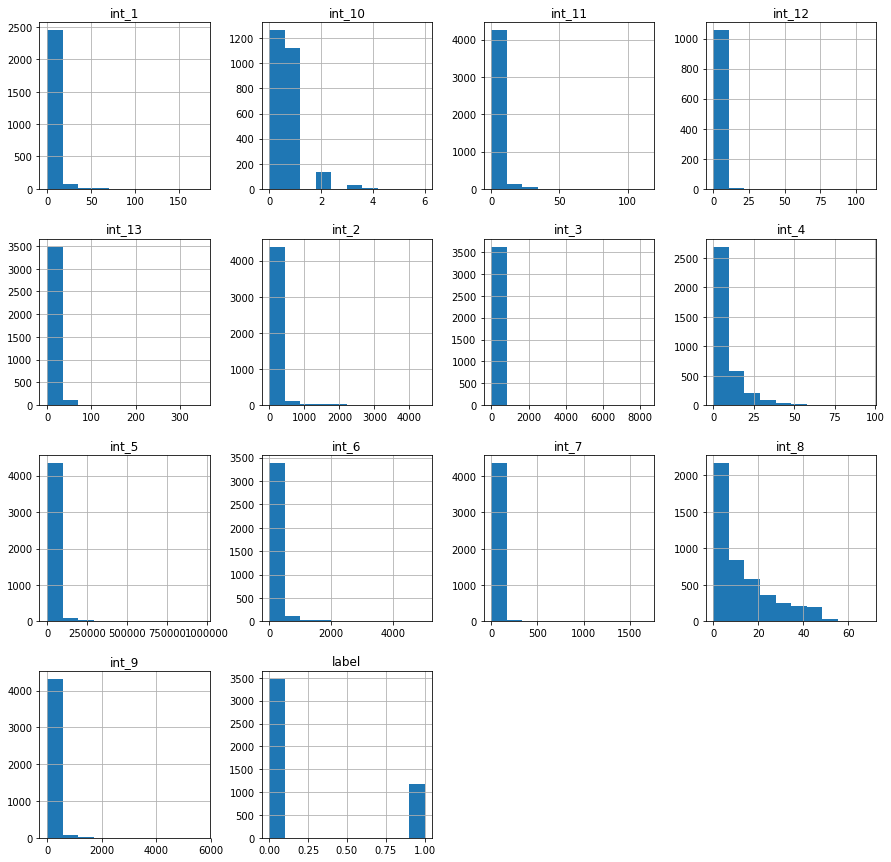

In [172]:
pd_sample_df.hist(figsize = (15,15))

## Algorithm Explanation - With Toy Example

As we have shown that we have met all the assumptions for logistic regression, we will proceed to use it for our Click Through Rate prediction task.

Before we perform the prediction on the Criteo dataset, we will begin by explaining the methodology behind how to apply linear regression to a dataset with a mix of numerical and categorical columns.

In [89]:
??parse_raw_df

In [94]:
toy_rawDF = sqlContext.read.text('gs://w261_final_project_ajh_bucket/data/Toy_Example_Data.csv').withColumnRenamed("value", "text")


In [95]:
def parse_point_toy(point):
    """Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    values = point.split(',')[1:]
    #values = filter(None, values)
    indices = range(len(values))
    return zip(indices,values)

In [96]:
from pyspark.sql.functions import udf, split
from pyspark.sql.types import ArrayType, StructType, StructField, LongType, StringType, FloatType, DoubleType


parse_point_toy_udf = udf(parse_point_toy, ArrayType(StructType([StructField('_1', LongType()),StructField('_2', StringType())])))

def parse_toy_raw_df(raw_df):
    """Convert a DataFrame consisting of rows of comma separated text into labels and feature.


    Args:
        raw_df: DataFrame containing the raw comma separated data.

    Returns:
        DataFrame: A DataFrame with 'label' and 'feature' columns.   
  
    """
    return (raw_df.select(split(raw_df.text,',').getItem(0).cast("double").alias('label'),
                         parse_point_toy_udf(raw_df.text).alias('features'))
                        .cache())

In [97]:
def toy_create_one_hot_dict(input_df):
    """Creates a one-hot-encoder dictionary based on the input data.

    Args:
        input_df (DataFrame with 'features' column): A DataFrame where each row contains a list of
            (featureID, value) tuples.

    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    input_distinct_feats_df = input_df.select(explode(input_df.features)).distinct()
    input_ohe_dict = (input_distinct_feats_df
                     .rdd
                     .map(lambda r: tuple(r[0]))
                     .zipWithIndex().collectAsMap())
    return input_ohe_dict

In [98]:
from pyspark.sql.functions import udf
from pyspark.mllib.linalg import VectorUDT

def toy_ohe_udf_generator(ohe_dict_broadcast):
    """Generate a UDF that is setup to one-hot-encode rows with the given dictionary.

    Note:
        We'll reuse this function to generate a UDF that can one-hot-encode rows based on a
        one-hot-encoding dictionary built from the training data.  Also, you should calculate
        the number of features before calling the toy_one_hot_encoding function.

    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.

    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the toy_one_hot_encoding
            function with the appropriate parameters.
    """
    length = len(ohe_dict_broadcast.value)
    return udf(lambda x: toy_one_hot_encoding(x, ohe_dict_broadcast, length), VectorUDT())


In [99]:
from pyspark.mllib.linalg import SparseVector
def toy_one_hot_encoding(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted.

    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    indices = sorted([ohe_dict_broadcast.value[feat] for feat in raw_feats])
    values = np.ones(len(raw_feats))
    return SparseVector(num_ohe_feats,indices,values)

In [100]:
toy_rawDF.show()


+--------------------+
|                text|
+--------------------+
|1,4,6.37,2.85,0,A...|
|1,5,7.84,3.91,1,S...|
|1,2,5.5,2.82,1,St...|
|1,3,8.43,1.92,1,E...|
|0,4,6.29,3.43,1,F...|
|1,4,8.36,1.91,1,J...|
|1,4,6.56,3.61,1,B...|
|0,2,7.98,1.96,0,F...|
|1,4,5.52,2.85,0,C...|
|1,3,9.15,3.34,0,F...|
|1,4,6.14,1.82,1,M...|
|0,4,6.87,1.75,1,J...|
|1,3,6.9,3.84,1,Sp...|
|1,2,6.53,1.57,0,A...|
|1,4,9.98,3.66,1,S...|
|0,2,9.78,2.81,1,M...|
|0,2,5.1,3.32,1,St...|
|1,3,5.32,3.62,1,A...|
|1,2,7.16,3.72,1,C...|
|0,3,6.07,2.29,0,R...|
+--------------------+
only showing top 20 rows



In [102]:
weights = [.8, .1, .1]
seed = 42
# Use randomSplit with weights and seed
raw_toy_train_df, raw_toy_validation_df, raw_toy_test_df = toy_rawDF.randomSplit(weights, seed)

# Cache and count the DataFrames
n_toy_train = raw_toy_train_df.cache().count()
n_toy_val = raw_toy_validation_df.cache().count()
n_toy_test = raw_toy_test_df.cache().count()
print(n_toy_train, n_toy_val, n_toy_test, str(n_toy_train + n_toy_val + n_toy_test))

806 94 100 1000


In [103]:
parsed_toy_train_df = parse_toy_raw_df(raw_toy_train_df)
print(parsed_toy_train_df.head())

Row(label=0.0, features=[Row(_1=0, _2='2'), Row(_1=1, _2='5.01'), Row(_1=2, _2='2.41'), Row(_1=3, _2='1'), Row(_1=4, _2='Math'), Row(_1=5, _2='German')])


In [104]:
from pyspark.sql.functions import (explode, col)
num_toy_categories = (parsed_toy_train_df
                    .select(explode('features').alias('features'))
                    .distinct()
                    .select(col('features').getField('_1').alias('featureNumber'))
                    .groupBy('featureNumber')
                    .sum()
                    .orderBy('featureNumber')
                    .collect())

In [105]:
print(num_toy_categories)

[Row(featureNumber=0, sum(featureNumber)=0), Row(featureNumber=1, sum(featureNumber)=402), Row(featureNumber=2, sum(featureNumber)=480), Row(featureNumber=3, sum(featureNumber)=6), Row(featureNumber=4, sum(featureNumber)=68), Row(featureNumber=5, sum(featureNumber)=85)]


In [106]:
toy_ohe_dict = toy_create_one_hot_dict(parsed_toy_train_df)
num_toy_ohe_feats = len(toy_ohe_dict)
print(num_toy_ohe_feats)

682


682

In [107]:
toy_ohe_dict_broadcast = sc.broadcast(toy_ohe_dict)
toy_ohe_dict_udf =  toy_ohe_udf_generator(toy_ohe_dict_broadcast)
toy_ohe_train_df =  parsed_toy_train_df.select(toy_ohe_dict_udf(parsed_toy_train_df.features).alias('features'),parsed_toy_train_df.label,)
#ohe_train_df.show(1)                  

print(toy_ohe_train_df.count())
print(toy_ohe_train_df.show())
print(toy_ohe_train_df.take(1))

806
+--------------------+-----+
|            features|label|
+--------------------+-----+
|(682,[82,113,117,...|  0.0|
|(682,[23,82,185,3...|  0.0|
|(682,[70,82,234,2...|  0.0|
|(682,[82,355,418,...|  0.0|
|(682,[82,462,576,...|  0.0|
|(682,[176,378,418...|  0.0|
|(682,[260,378,418...|  0.0|
|(682,[378,414,447...|  0.0|
|(682,[217,378,522...|  0.0|
|(682,[235,378,536...|  0.0|
|(682,[82,151,152,...|  0.0|
|(682,[82,230,272,...|  0.0|
|(682,[160,227,378...|  0.0|
|(682,[82,153,160,...|  0.0|
|(682,[131,182,348...|  0.0|
|(682,[67,82,137,5...|  0.0|
|(682,[32,137,250,...|  0.0|
|(682,[82,137,154,...|  0.0|
|(682,[117,267,330...|  0.0|
|(682,[82,144,370,...|  0.0|
+--------------------+-----+
only showing top 20 rows

None
[Row(features=SparseVector(682, {82: 1.0, 113: 1.0, 117: 1.0, 413: 1.0, 502: 1.0, 674: 1.0}), label=0.0)]


In [108]:
toy_ohe_train_rdd = toy_ohe_train_df \
                     .rdd \
                     .cache()

In [109]:
meanDropOut = toy_ohe_train_rdd.map(lambda x: x[1]).mean()
varDropOut = toy_ohe_train_rdd.map(lambda x: x[1]).variance()
numDropOut = toy_ohe_train_rdd.map(lambda x: x[1]).sum()/toy_ohe_train_df.count()
print(f"PercentDropOut: {numDropOut}")
print(f"Mean: {meanDropOut}")
print(f"Variance: {varDropOut}")

PercentDropOut: 0.6625310173697271
Mean: 0.6625310173697274
Variance: 0.2235836683927612


In [110]:
BASELINE = np.append(meanDropOut, np.zeros(num_toy_ohe_feats))

In [111]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [116]:
def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, 
                    learningRate = 0.01, verbose = False):
    """
    Perform nSteps iterations of gradient descent and 
    track loss on a test and train set. Return lists of
    test/train loss and the models themselves.
    """
    # initialize lists to track model performance
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps):  
        model = GDUpdate(trainRDD, model, learningRate)
        training_loss = LogLoss(trainRDD, model) 
        test_loss = LogLoss(testRDD, model)
        
        # keep track of test/train loss for plotting
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
        # console output if desired
        if verbose:
            print("----------")
            print(f"STEP: {idx+1}")
            print(f"training loss: {training_loss}")
            print(f"test loss: {test_loss}")
            print(f"Model: {[round(w,3) for w in model]}")
    return train_history, test_history, model_history

In [114]:
def LogLoss(dataRDD, W):
    """
    Compute log loss.
    Args:
        dataRDD - each record is a tuple of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    """
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    loss = augmentedData.map(lambda x: (-x[1] * np.log(sigmoid(W.dot(x[0]))) \
                                     - (1 - x[1]) * np.log(1 - sigmoid(W.dot(x[0])))) ).mean()
    return loss

In [115]:
def GDUpdate(dataRDD, W, learningRate = 0.1):
    """
    Perform one step/update on the Logistic regression.
    Args:
        dataRDD - records are tuples of (features_array, y)
        W       - (array) model coefficients with bias at index 0
    Returns:
        new_model - (array) updated coefficients, bias at index 0
    """
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    grad = augmentedData.map(lambda x: np.dot(sigmoid(W.dot(x[0]) - x[1]),x[0])).mean()
    new_model = W - learningRate * grad
    
    return new_model

In [118]:
nSteps = 5
model = BASELINE
print(f"BASELINE:  Loss = {LogLoss(toy_ohe_train_rdd,model)}")
for idx in range(nSteps):
    print("----------")
    print(f"STEP: {idx+1}")
    model = GDUpdate(toy_ohe_train_rdd, model)
    loss = LogLoss(toy_ohe_train_rdd, model)
    print(f"Loss: {loss}")
  #  print(f"Model: {[round(w,3) for w in model]}")

BASELINE:  Loss = 0.6393586657271466
----------
STEP: 1
Loss: 0.6405834992567013
----------
STEP: 2
Loss: 0.643721487215732
----------
STEP: 3
Loss: 0.6485545689963543
----------
STEP: 4
Loss: 0.6548778151932536
----------
STEP: 5
Loss: 0.6625012704436208


In [123]:
# run 50 iterations (RUN THIS CELL AS IS)
wInit = BASELINE
trainRDD, testRDD = toy_ohe_train_rdd.randomSplit([0.8,0.2], seed = 2018)
start = time.time()
train, test, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)
print(f"\n... trained {len(models)} iterations in {time.time() - start} seconds")


... trained 50 iterations in 622.8087210655212 seconds


In [119]:
def toy_one_hot_encoding_v2(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted, and that the
        function handles missing features.

    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    indices = sorted([ohe_dict_broadcast.value[feat] for feat in raw_feats if feat in ohe_dict_broadcast.value])
    values = np.ones(len([feat for feat in raw_feats if feat in ohe_dict_broadcast.value] ))
#     values = np.ones(len([raw_feats]))
    return SparseVector(num_ohe_feats,indices,values)

def toy_ohe_udf_generator_v2(ohe_dict_broadcast):
    """Generate a UDF that is setup to one-hot-encode rows with the given dictionary.

    Note:
        We'll reuse this function to generate a UDF that can one-hot-encode rows based on a
        one-hot-encoding dictionary built from the training data.  Also, you should calculate
        the number of features before calling the one_hot_encoding function.

    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.

    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the one_hot_encoding
            function with the appropriate parameters.
    """
    length = len(ohe_dict_broadcast.value)
    return udf(lambda x: toy_one_hot_encoding_v2(x, ohe_dict_broadcast, length), VectorUDT())

In [120]:
#test
toy_ohe_dict_missing_udf = toy_ohe_udf_generator_v2(toy_ohe_dict_broadcast)

toy_ohe_test_df = parsed_toy_train_df.select(toy_ohe_dict_missing_udf(parsed_toy_train_df.features).alias('features'), parsed_toy_train_df.label,).cache()
print(toy_ohe_test_df.count())
print(toy_ohe_test_df.show())
print(toy_ohe_test_df.take(1))

806
+--------------------+-----+
|            features|label|
+--------------------+-----+
|(682,[82,113,117,...|  0.0|
|(682,[23,82,185,3...|  0.0|
|(682,[70,82,234,2...|  0.0|
|(682,[82,355,418,...|  0.0|
|(682,[82,462,576,...|  0.0|
|(682,[176,378,418...|  0.0|
|(682,[260,378,418...|  0.0|
|(682,[378,414,447...|  0.0|
|(682,[217,378,522...|  0.0|
|(682,[235,378,536...|  0.0|
|(682,[82,151,152,...|  0.0|
|(682,[82,230,272,...|  0.0|
|(682,[160,227,378...|  0.0|
|(682,[82,153,160,...|  0.0|
|(682,[131,182,348...|  0.0|
|(682,[67,82,137,5...|  0.0|
|(682,[32,137,250,...|  0.0|
|(682,[82,137,154,...|  0.0|
|(682,[117,267,330...|  0.0|
|(682,[82,144,370,...|  0.0|
+--------------------+-----+
only showing top 20 rows

None
[Row(features=SparseVector(682, {82: 1.0, 113: 1.0, 117: 1.0, 413: 1.0, 502: 1.0, 674: 1.0}), label=0.0)]


In [121]:
toy_ohe_test_rdd = toy_ohe_test_df \
                     .rdd \
                     .cache()

In [124]:
#MSE = LogLoss(ohe_test_rdd, models)
toy_train_model = np.asarray(models[-1])
LogLoss(toy_ohe_test_rdd, toy_train_model)

0.6617741806149889

## Algorithm Implementation

In [20]:
weights = [0.8, 0.1, 0.1]
seed = 1

# Use randomSplit with weights and seed
rawTrainDF, rawValidationDF, rawTestDF = rawDF.randomSplit(weights, seed)


In [21]:
#25% sampling due to memory errors
rawTrainNewDF = rawTrainDF.sample(withReplacement=False, fraction=0.25, seed=1)

In [22]:
rawTrainNewDF.cache()
rawValidationDF.cache()
rawTestDF.cache()

DataFrame[text: string]

In [23]:
rawTrainNewDF.count()

9167896

In [31]:
trainWithColsDF = rawTrainNewDF.withColumn('tmp', split('text', '\t')).\
                    select( col("tmp").getItem(0).cast("double").alias("label")
                    , col("tmp").getItem(1).cast("double").alias("int_1")
                    , col("tmp").getItem(2).cast("double").alias("int_2")
                    , col("tmp").getItem(3).cast("double").alias("int_3")
                    , col("tmp").getItem(4).cast("double").alias("int_4")
                    , col("tmp").getItem(5).cast("double").alias("int_5")
                    , col("tmp").getItem(6).cast("double").alias("int_6")
                    , col("tmp").getItem(7).cast("double").alias("int_7")
                    , col("tmp").getItem(8).cast("double").alias("int_8")
                    , col("tmp").getItem(9).cast("double").alias("int_9")
                    , col("tmp").getItem(10).cast("double").alias("int_10")
                    , col("tmp").getItem(11).cast("double").alias("int_11")
                    , col("tmp").getItem(12).cast("double").alias("int_12")
                    , col("tmp").getItem(13).cast("double").alias("int_13")
                    , col("tmp").getItem(14).alias("categ_1")
                    , col("tmp").getItem(15).alias("categ_2")
                    , col("tmp").getItem(16).alias("categ_3")
                    , col("tmp").getItem(17).alias("categ_4")
                    , col("tmp").getItem(18).alias("categ_5")
                    , col("tmp").getItem(19).alias("categ_6")
                    , col("tmp").getItem(20).alias("categ_7")
                    , col("tmp").getItem(21).alias("categ_8")
                    , col("tmp").getItem(22).alias("categ_9")
                    , col("tmp").getItem(23).alias("categ_10")
                    , col("tmp").getItem(24).alias("categ_11")
                    , col("tmp").getItem(25).alias("categ_12")
                    , col("tmp").getItem(26).alias("categ_13")
                    , col("tmp").getItem(27).alias("categ_14")
                    , col("tmp").getItem(28).alias("categ_15")
                    , col("tmp").getItem(29).alias("categ_16")
                    , col("tmp").getItem(30).alias("categ_17")
                    , col("tmp").getItem(31).alias("categ_18")
                    , col("tmp").getItem(32).alias("categ_19")
                    , col("tmp").getItem(33).alias("categ_20")
                    , col("tmp").getItem(34).alias("categ_21")
                    , col("tmp").getItem(35).alias("categ_22")
                    , col("tmp").getItem(36).alias("categ_23")
                    , col("tmp").getItem(37).alias("categ_24")
                    , col("tmp").getItem(38).alias("categ_25")
                    , col("tmp").getItem(39).alias("categ_26")
                    ).cache()

In [34]:
def one_hot_encoding(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        You should ensure that the indices used to create a SparseVector are sorted, and that the
        function handles missing features.

    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    #indices = sorted([ohe_dict_broadcast.value[feat] for feat in raw_feats if feat in ohe_dict_broadcast.value])
    indices = sorted([ohe_dict_broadcast.value[feat] for feat in raw_feats])
    values = np.ones(len(raw_feats))
    return SparseVector(num_ohe_feats,indices,values)


In [35]:
def ohe_udf_generator(ohe_dict_broadcast):
    """Generate a UDF that is setup to one-hot-encode rows with the given dictionary.

    Note:
        We'll reuse this function to generate a UDF that can one-hot-encode rows based on a
        one-hot-encoding dictionary built from the training data.  Also, you should calculate
        the number of features before calling the one_hot_encoding function.

    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.

    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the one_hot_encoding
            function with the appropriate parameters.
    """
    length = len(ohe_dict_broadcast.value)
    return udf(lambda x: one_hot_encoding(x, ohe_dict_broadcast, length), VectorUDT())



In [36]:
def create_one_hot_dict(input_df):
    """Creates a one-hot-encoder dictionary based on the input data.

    Args:
        input_df (DataFrame with 'features' column): A DataFrame where each row contains a list of
            (featureID, value) tuples.

    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
    """
    input_distinct_feats_df = input_df.select(explode(input_df.features)).distinct()
    input_ohe_dict = (input_distinct_feats_df
                     .rdd
                     .map(lambda r: tuple(r[0]))
                     .zipWithIndex().collectAsMap())
    return input_ohe_dict



In [125]:
def parse_point(point):
    """ Converts a comma separated string into a list of (featureID, value) tuples.

    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Arguments:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
    """
    values = point.split('\t')[1:]
    indices = range(len(values))
    return zip(indices,values)


In [126]:
parse_point_udf = udf(parse_point, ArrayType(StructType([StructField('_1', LongType()),StructField('_2', StringType())])))

def parse_raw_df(raw_df):
    """ Will transform a DataFrame with comma separated text into labels and feature.

    Arguments:
        raw_df (DataFrame with a 'text' column): DataFrame containing the raw comma separated data.

    Returns:
        DataFrame: A DataFrame with 'label' and 'feature' columns.   
    """
    return (raw_df.select(split(raw_df.text,'\t').getItem(0).cast("double").alias('label'),
                         parse_point_udf(raw_df.text).alias('features'))
                        .cache())


In [37]:
parsed_train_df = parse_raw_df(rawTrainNewDF)
parsed_validation_df = parse_raw_df(rawValidationDF)
parsed_test_df = parse_raw_df(rawTestDF)


In [38]:
parsed_train_df.cache()
parsed_validation_df.cache()
parsed_test_df.cache()


DataFrame[label: double, features: array<struct<_1:bigint,_2:string>>]

In [39]:
parsed_train_df.count()

9167896

In [40]:
parsed_train_df.head()

Row(label=0.0, features=[Row(_1=0, _2=''), Row(_1=1, _2='-1'), Row(_1=2, _2=''), Row(_1=3, _2=''), Row(_1=4, _2=''), Row(_1=5, _2=''), Row(_1=6, _2=''), Row(_1=7, _2=''), Row(_1=8, _2=''), Row(_1=9, _2=''), Row(_1=10, _2=''), Row(_1=11, _2=''), Row(_1=12, _2=''), Row(_1=13, _2='05db9164'), Row(_1=14, _2='38a947a1'), Row(_1=15, _2=''), Row(_1=16, _2=''), Row(_1=17, _2='25c83c98'), Row(_1=18, _2=''), Row(_1=19, _2='1d7560d9'), Row(_1=20, _2='64523cfa'), Row(_1=21, _2='7cc72ec2'), Row(_1=22, _2='3b08e48b'), Row(_1=23, _2='8951ed6a'), Row(_1=24, _2=''), Row(_1=25, _2='27dc8af3'), Row(_1=26, _2='b28479f6'), Row(_1=27, _2='4df46b2c'), Row(_1=28, _2=''), Row(_1=29, _2='2005abd1'), Row(_1=30, _2='40685634'), Row(_1=31, _2=''), Row(_1=32, _2=''), Row(_1=33, _2=''), Row(_1=34, _2=''), Row(_1=35, _2='32c7478e'), Row(_1=36, _2=''), Row(_1=37, _2=''), Row(_1=38, _2='')])

In [41]:
num_categories = (parsed_train_df
                    .select(explode('features').alias('features'))
                    .distinct()
                    .select(col('features').getField('_1').alias('featureNumber'))
                    .groupBy('featureNumber')
                    .sum()
                    .orderBy('featureNumber')
                    .collect())


In [42]:
num_categories

[Row(featureNumber=0, sum(featureNumber)=0),
 Row(featureNumber=1, sum(featureNumber)=6850),
 Row(featureNumber=2, sum(featureNumber)=11562),
 Row(featureNumber=3, sum(featureNumber)=876),
 Row(featureNumber=4, sum(featureNumber)=1024108),
 Row(featureNumber=5, sum(featureNumber)=36790),
 Row(featureNumber=6, sum(featureNumber)=16362),
 Row(featureNumber=7, sum(featureNumber)=5229),
 Row(featureNumber=8, sum(featureNumber)=41136),
 Row(featureNumber=9, sum(featureNumber)=99),
 Row(featureNumber=10, sum(featureNumber)=1470),
 Row(featureNumber=11, sum(featureNumber)=2915),
 Row(featureNumber=12, sum(featureNumber)=8088),
 Row(featureNumber=13, sum(featureNumber)=18954),
 Row(featureNumber=14, sum(featureNumber)=7868),
 Row(featureNumber=15, sum(featureNumber)=38094315),
 Row(featureNumber=16, sum(featureNumber)=11218608),
 Row(featureNumber=17, sum(featureNumber)=5185),
 Row(featureNumber=18, sum(featureNumber)=414),
 Row(featureNumber=19, sum(featureNumber)=232522),
 Row(featureNumber=

### Create an OHE dictionary from the dataset


In [43]:
ctr_ohe_dict = create_one_hot_dict(parsed_train_df)
num_ctr_ohe_feats = len(ctr_ohe_dict)
print(num_ctr_ohe_feats)
print(ctr_ohe_dict[(0, '')])


9444472
8499753


### Apply OHE to the dataset


In [53]:
ohe_dict_broadcast = sc.broadcast(ctr_ohe_dict)
ohe_dict_udf =  ohe_udf_generator(ohe_dict_broadcast)


In [54]:
ohe_train_df =  parsed_train_df.select(parsed_train_df.label, ohe_dict_udf(parsed_train_df.features).alias('features'))
ohe_train_df.cache()


DataFrame[label: double, features: vector]

### (3f) Handling unseen features


In [55]:
def one_hot_encoding_v2(raw_feats, ohe_dict_broadcast, num_ohe_feats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.
    The indices used to create a SparseVector are sorted. We consider previously seen features only.

    Args:
        raw_feats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sample_one)
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.
        num_ohe_feats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length num_ohe_feats with indices equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    indices = sorted([ohe_dict_broadcast.value[feat] for feat in raw_feats if feat in ohe_dict_broadcast.value])
    values = np.ones(len([feat for feat in raw_feats if feat in ohe_dict_broadcast.value] ))
    return SparseVector(num_ohe_feats,indices,values)

def ohe_udf_generator_v2(ohe_dict_broadcast):
    """Generate a UDF that is setup to one-hot-encode rows with the given dictionary.

    Args:
        ohe_dict_broadcast (Broadcast of dict): Broadcast variable containing a dict that maps
            (featureID, value) to unique integer.

    Returns:
        UserDefinedFunction: A UDF can be used in `DataFrame` `select` statement to call a
            function on each row in a given column.  This UDF should call the one_hot_encoding
            function with the appropriate parameters.
    """
    length = len(ohe_dict_broadcast.value)
    return udf(lambda x: one_hot_encoding_v2(x, ohe_dict_broadcast, length), VectorUDT())


In [56]:
ohe_dict_missing_udf = ohe_udf_generator_v2(ohe_dict_broadcast)

ohe_test_df = parsed_test_df.select(parsed_test_df.label,  ohe_dict_missing_udf(parsed_test_df.features).alias('features')).cache()



In [57]:
print(ohe_test_df.count())
print(ohe_test_df.show(1, truncate=False))


4585725
+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|label|features                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
+-----+-------------

In [58]:
ohe_train_df.first()

Row(label=0.0, features=SparseVector(9444472, {282595: 1.0, 424288: 1.0, 659969: 1.0, 706928: 1.0, 989935: 1.0, 1320318: 1.0, 1557022: 1.0, 1557023: 1.0, 1557024: 1.0, 2123496: 1.0, 2264580: 1.0, 2406696: 1.0, 2736370: 1.0, 3113587: 1.0, 3255788: 1.0, 4010909: 1.0, 4153235: 1.0, 4200705: 1.0, 4200706: 1.0, 4296513: 1.0, 4814588: 1.0, 4909212: 1.0, 5146054: 1.0, 5524541: 1.0, 5808565: 1.0, 5903003: 1.0, 6233661: 1.0, 6611261: 1.0, 6705776: 1.0, 6895237: 1.0, 7602305: 1.0, 8074256: 1.0, 8358485: 1.0, 8405758: 1.0, 8452489: 1.0, 8499753: 1.0, 9161299: 1.0, 9350284: 1.0, 9350285: 1.0}))

In [59]:
ohe_test_df.first()

Row(label=0.0, features=SparseVector(9444472, {282595: 1.0, 424288: 1.0, 659969: 1.0, 706928: 1.0, 1320318: 1.0, 1557022: 1.0, 1557024: 1.0, 1604080: 1.0, 2264580: 1.0, 2406696: 1.0, 2500884: 1.0, 2736370: 1.0, 3113587: 1.0, 3255788: 1.0, 4010909: 1.0, 4058045: 1.0, 4153235: 1.0, 4200705: 1.0, 4578630: 1.0, 4814588: 1.0, 4909212: 1.0, 5146054: 1.0, 5524541: 1.0, 5808565: 1.0, 5855851: 1.0, 6091432: 1.0, 6233661: 1.0, 6611261: 1.0, 6705776: 1.0, 7602305: 1.0, 7884943: 1.0, 8074256: 1.0, 8358485: 1.0, 8405758: 1.0, 8452489: 1.0, 8499753: 1.0, 9161299: 1.0, 9350284: 1.0, 9350285: 1.0}))

## Part 4: CTR prediction and logloss evaluation


### (4a) Logistic regression


In [61]:
standardization = True
elastic_net_param = 0.0
reg_param = .01
max_iter = 5

lr = LogisticRegression(featuresCol="features", labelCol="label", predictionCol="prediction", maxIter=max_iter, regParam=reg_param, elasticNetParam=elastic_net_param, fitIntercept=True,  standardization=standardization)

lr_model_basic = lr.fit(ohe_train_df)

print('intercept: {0}'.format(lr_model_basic.intercept))
print('length of coefficients: {0}'.format(len(lr_model_basic.coefficients)))
sorted_coefficients = sorted(lr_model_basic.coefficients)[:5]
print(sorted_coefficients)


intercept: -1.0743401568315318
length of coefficients: 9444472
[-2.3933778261858674, -2.3640446886325717, -2.3606764183110305, -2.356334312584443, -2.345188385115328]


### (4b) Log loss


In [62]:
from pyspark.sql.functions import when, log, col
epsilon = 1e-16

def add_log_loss(df):
    """Computes and adds a 'log_loss' column to a DataFrame using 'p' and 'label' columns.

    Note:
        log(0) is undefined, so when p is 0 we add a small value (epsilon) to it and when
        p is 1 we subtract a small value (epsilon) from it.

    Args:
        df (DataFrame with 'p' and 'label' columns): A DataFrame with a probability column
            'p' and a 'label' column that corresponds to y in the log loss formula.

    Returns:
        DataFrame: A new DataFrame with an additional column called 'log_loss' where 'log_loss' column contains the loss value as explained above.
        
        if y == 1:
          return -log(epsilon + p) if p == 0 else -log(p)
        elif y == 0:
          return -log(1 - p + epsilon) if p == 1 else -log(1 - p)         
    """
    
    return (df.select(df['p'],df['label'],
                when(df['label']==1.0,
                     (when(df['p']!=0,-log(df['p'])))
                     .otherwise(-log(epsilon + df['p'])))
               .when(df['label']==0.0,
                     (when(df['p']!=1.0,-log(1.0-df['p'])))
                     .otherwise(-log(1.0 - df['p'] + epsilon)))
               .alias("log_loss")))



## (4c) Baseline log loss


In [63]:
from pyspark.sql.functions import lit
class_one_frac_train = ohe_train_df.select(F.sum('label')).collect()[0][0] / ohe_train_df.count()

ohe_train_df = (ohe_train_df.withColumn("p", lit(class_one_frac_train)))
print('Training class one fraction = {0:.3f}'.format(class_one_frac_train))

log_loss_tr_base = (add_log_loss(ohe_train_df).select(F.sum('log_loss')).collect()[0][0] / ohe_train_df.count())
print('Baseline Train Logloss = {0:.3f}\n'.format(log_loss_tr_base))


Training class one fraction = 0.256
Baseline Train Logloss = 0.569



### Predicting probability

In [64]:
from pyspark.sql.types import DoubleType
from math import exp #  exp(-t) = e^-t

def add_probability(df, model):
    """Adds a probability column ('p') to a DataFrame given a model
    Args:
        df for which probability has to be calculated.
        model with which probability has to be calculated

    Returns:
        DataFrame: A new DataFrame with an additional column called p where p column contains the probability for an observation given a list of features.
    
    """
    coefficients_broadcast = sc.broadcast(model.coefficients)
    intercept = model.intercept

    def get_p(features):
        """Calculate the probability for an observation given a list of features.

        Note:
            We'll bound our raw prediction between 20 and -20 for numerical purposes.

        Args:
            features: the features

        Returns:
            float: A probability between 0 and 1.
        """
        # Compute the raw value
        raw_prediction = features.dot(coefficients_broadcast.value)+intercept
        # Bound the raw value between 20 and -20
        raw_prediction = min(raw_prediction, 20)
        raw_prediction = max(raw_prediction, -20)
        return 1.0 / (1.0 + exp(-raw_prediction))

    get_p_udf = udf(get_p, DoubleType())
    return df.withColumn('p', get_p_udf('features'))



In [65]:
add_probability_model_basic = lambda df: add_probability(df, lr_model_basic)
training_predictions = add_probability_model_basic(ohe_train_df).cache()
training_predictions.show(5, truncate=False)


+-----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------------+
|label|features                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |p       

In [66]:
training_predictions.show(5)


+-----+--------------------+--------------------+
|label|            features|                   p|
+-----+--------------------+--------------------+
|  0.0|(9444472,[282595,...| 0.03797345839906773|
|  0.0|(9444472,[282595,...| 0.04075749313455165|
|  0.0|(9444472,[282595,...|  0.0602396726700737|
|  0.0|(9444472,[235571,...|0.058502976931045676|
|  0.0|(9444472,[282595,...| 0.09565946274868178|
+-----+--------------------+--------------------+
only showing top 5 rows



### Evaluating the model


In [67]:
def evaluate_results(df, model, baseline=None):
    """Calculates the log loss for the data given the model.

    Note:
        If baseline has a value the probability should be set to baseline before
        the log loss is calculated.  Otherwise, use add_probability to add the
        appropriate probabilities to the DataFrame.

    Args:
        df (DataFrame with 'label' and 'features' columns): A DataFrame containing
            labels and features.
        model (LogisticRegressionModel): A trained logistic regression model. This
            can be None if baseline is set.
        baseline (float): A baseline probability to use for the log loss calculation.

    Returns:
        float: Log loss for the data.
    """
    with_probability_df = add_probability(df, model)
    with_log_loss_df = add_log_loss(with_probability_df)
    log_loss = (with_log_loss_df.select(F.sum('log_loss')).collect()[0][0] / with_log_loss_df.count())
    return log_loss


In [68]:
log_loss_train_model_basic = evaluate_results(ohe_train_df, lr_model_basic)
print ('OHE Features Train Logloss:\n\tBaseline = {0:.3f}\n\tLogReg = {1:.3f}'
       .format(log_loss_tr_base, log_loss_train_model_basic))


OHE Features Train Logloss:
	Baseline = 0.569
	LogReg = 0.335


### (4f) Test dataset log loss


In [69]:
log_loss_val = evaluate_results(ohe_test_df, lr_model_basic)


In [70]:
log_loss_val

0.4948208635641279

In [71]:
test_predictions = add_probability_model_basic(ohe_test_df).cache()
test_predictions.show(5)


+-----+--------------------+-------------------+
|label|            features|                  p|
+-----+--------------------+-------------------+
|  0.0|(9444472,[282595,...| 0.0758689589710484|
|  0.0|(9444472,[235572,...| 0.0400414644520275|
|  0.0|(9444472,[47175,1...|0.10946047756433618|
|  0.0|(9444472,[95297,4...|0.03827244701048019|
|  0.0|(9444472,[424288,...|0.13123500785370285|
+-----+--------------------+-------------------+
only showing top 5 rows



In [72]:
test_predictions.withColumn("Probability",F.round(col("p"),2) ).groupBy("Probability").agg(F.count(lit(1)).alias("count")).show()
                             

+-----------+------+
|Probability| count|
+-----------+------+
|       0.66| 14531|
|       0.07|149394|
|       0.84|  6620|
|       0.87|  5837|
|        0.0|  4639|
|       0.16|110505|
|       0.93|  5016|
|       0.89|  5339|
|       0.18|100581|
|        0.2| 92191|
|       0.05|149975|
|       0.39| 39944|
|       0.79|  8147|
|       0.72| 11352|
|        0.7| 12170|
|       0.24| 76046|
|       0.54| 22642|
|       0.21| 87714|
|        0.1|139554|
|       0.45| 31639|
+-----------+------+
only showing top 20 rows



In [1]:
#Reference :
#RandomForest
#https://github.com/apache/spark/blob/v2.2.0/mllib/src/main/scala/org/apache/spark/ml/classification/RandomForestClassifier.scala#L120
#One hot encoding
#https://towardsdatascience.com/machine-learning-with-pyspark-and-mllib-solving-a-binary-classification-problem-96396065d2aa
#LR from scratch
#https://medium.com/@martinpella/logistic-regression-from-scratch-in-python-124c5636b8ac
#https://www.programcreek.com/python/example/106727/pyspark.ml.feature.StringIndexer

#pyspark.mllib vs pyspark.ml
#https://stackoverflow.com/questions/41074182/cannot-convert-type-class-pyspark-ml-linalg-sparsevector-into-vector